# 라이브러리 불러오기

In [1]:
import sys
sys.path.append('src')
from en_system_ex_analysis.En_system_intergrated import *
from SALib.sample import saltelli
from SALib.analyze import sobol
import scipy.stats as st
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import dartwork_mpl as dm
import en_system_ex_analysis as cu
import seaborn as sns
from scipy.stats import norm, uniform, triang, gamma
import warnings
from pprint import pprint
warnings.filterwarnings("ignore")
import matplotlib.colors as mcolors
from matplotlib.cm import get_cmap
from matplotlib import cm
from matplotlib.patches import Patch
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.integrate import quad
from scipy.special import erfc
from scipy.integrate import dblquad
from matplotlib.ticker import LogLocator, LogFormatterMathtext
import concurrent.futures

dm.use_dmpl_style()


Load colors...
Load colormaps...


# 파라미터 값 지정

In [2]:
T_g   = 15        # initial ground temperature, °C
T_0   = 30        # environmental temperature, °C 
q     = 25        # heat flow rate per unit length, W/m
H     = 200       # total length of the GHE, m
k_g   = 2.0       # effective borehole thermal conductivity, W/(m·K)
c_g   = 800       # specific heat capacity of ground, J/(kg·K)
rho_g = 2000      # density of ground, kg/m³
alpha = k_g / (c_g * rho_g)    # thermal diffusivity of the ground, m²/s
r_b   = 0.08      # borehole radius, m
R_b   = 0.108     # effective borehole thermal resistance, (m·K)/W
c_f   = 4184      # specific heat of fluid, J/(kg·K)
rho_f = 1000      # density of fluid, kg/m³
V_f   = 0.0004     # volumetric flow rate of fluid, m³/s
D = 0

E_pmp = 200      # pump energy consumption, W

# 함수 지정 및 리스트 생성

In [3]:
def g_function(t):
    def integrand(z, h):
        term1 = np.sqrt(r_b**2 + (z - h)**2)
        term2 = np.sqrt(r_b**2 + (z + h)**2)
        val1 = erfc(term1 / (2 * np.sqrt(alpha * t))) / term1
        val2 = erfc(term2 / (2 * np.sqrt(alpha * t))) / term2
        return val1 - val2

    # t에 따라 정밀도 조절
    if t < 100*cu.h2s:
        epsabs, epsrel = 1e-30, 1e-30
    else:
        epsabs, epsrel = 1e-8, 1e-8

    # 적분 수행
    integral1, _ = dblquad(
        integrand,
        D, D + H,                 # h limits
        lambda z: D,              # z lower limit
        lambda z: D + H,          # z upper limit
        epsabs=epsabs,            # 정밀도 설정
        epsrel=epsrel
    )

    return integral1 / (4 * np.pi * k_g * H)

def Tf(t):
    return T_g + q * g_function(t) + q * R_b

def Tb(t):
    return T_g + q * g_function(t)

In [4]:
times_hour = np.logspace(0, 5, 2)
times_sec = times_hour * 3600

Tf_o_now = T_g

# --- 결과 저장 리스트 ---
Tf_i_list, Tf_o_list, Tf_list, Tb_list = [], [], [], []
X_in_ghe, X_c_ghe, X_out_ghe = [], [], []
X_in_ground, X_c_ground, X_out_ground = [], [], []
R_g_list = []

def compute_at_time(t):

    R_g = g_function(t)
    Tf_now = Tf(t)
    Tb_now = Tb(t)
    Tf_i_now = Tf_now + q * H / (2 * c_f * rho_f * V_f)
    Tf_o_now = Tf_now - q * H / (2 * c_f * rho_f * V_f)

    # GHE 엑서지
    X_in_ghe_now = (1 - cu.C2K(T_0) / cu.C2K(Tb_now)) * (- q * H) + E_pmp
    X_out_ghe_now = (
        c_f * rho_f * V_f *
        ((cu.C2K(Tf_o_now) - cu.C2K(T_0)) -
         cu.C2K(T_0) * np.log(cu.C2K(Tf_o_now) / cu.C2K(T_0)))
        -
        c_f * rho_f * V_f *
        ((cu.C2K(Tf_i_now) - cu.C2K(T_0)) -
         cu.C2K(T_0) * np.log(cu.C2K(Tf_i_now) / cu.C2K(T_0)))
    )
    X_c_ghe_now = X_in_ghe_now - X_out_ghe_now

    # Ground 엑서지
    X_in_ground_now = (1 - cu.C2K(T_0) / cu.C2K(T_g)) * (- q * H)
    X_out_ground_now = (1 - cu.C2K(T_0) / cu.C2K(Tb_now)) * (- q * H)
    X_c_ground_now = X_in_ground_now - X_out_ground_now

    return [
        R_g, Tf_i_now, Tf_o_now, Tf_now, Tb_now,
        X_in_ghe_now, X_out_ghe_now, X_c_ghe_now,
        X_in_ground_now, X_out_ground_now, X_c_ground_now
    ]

# --- 병렬 실행 ---
with concurrent.futures.ProcessPoolExecutor() as executor:
    results = list(executor.map(compute_at_time, times_sec))

for res in results:
    (R_g, Tf_i, Tf_o, Tf_val, Tb_val, Xin_g, Xout_g, Xc_g,
     Xin_gr, Xout_gr, Xc_gr) = res

    R_g_list.append(R_g)
    Tf_i_list.append(Tf_i)
    Tf_o_list.append(Tf_o)
    Tf_list.append(Tf_val)
    Tb_list.append(Tb_val)
    X_in_ghe.append(Xin_g)
    X_out_ghe.append(Xout_g)
    X_c_ghe.append(Xc_g)
    X_in_ground.append(Xin_gr)
    X_out_ground.append(Xout_gr)
    X_c_ground.append(Xc_gr)

# --- DataFrame 생성 및 저장 ---
df = pd.DataFrame({
    'time_hour': times_hour,
    'R_g': R_g_list,
    'Tf_i': Tf_i_list,
    'Tf_o': Tf_o_list,
    'Tf': Tf_list,
    'Tb': Tb_list,
    'X_in_ghe': X_in_ghe,
    'X_out_ghe': X_out_ghe,
    'X_c_ghe': X_c_ghe,
    'X_in_ground': X_in_ground,
    'X_out_ground': X_out_ground,
    'X_c_ground': X_c_ground,
})

df.to_csv('data/GHE_exergy.csv', index=False)
print("CSV 저장 완료.")


Traceback (most recent call last):
  File "C:\Users\pshps\AppData\Roaming\uv\python\cpython-3.11.11-windows-x86_64-none\Lib\multiprocessing\queues.py", line 246, in _feed
    send_bytes(obj)
  File "C:\Users\pshps\AppData\Roaming\uv\python\cpython-3.11.11-windows-x86_64-none\Lib\multiprocessing\connection.py", line 184, in send_bytes
    self._check_closed()
  File "C:\Users\pshps\AppData\Roaming\uv\python\cpython-3.11.11-windows-x86_64-none\Lib\multiprocessing\connection.py", line 137, in _check_closed
    raise OSError("handle is closed")
OSError: handle is closed


BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.

cvs 파일 불러오기

In [3]:
data = pd.read_csv('data/GHE_exergy.csv')

times_hour = np.logspace(0, 5, 200)

R_g_list = data['R_g'] 

Tf_i_list = data['Tf_i']
Tf_o_list = data['Tf_o']
Tf_list = data['Tf']
Tb_list = data['Tb']

X_in_ghe = data['X_in_ghe']
X_c_ghe = data['X_c_ghe']
X_out_ghe = data['X_out_ghe']

X_in_ground = data['X_in_ground']
X_c_ground = data['X_c_ground']
X_out_ground = data['X_out_ground']

In [4]:
import numpy as np

times_hour = np.logspace(0, 5, 200)
target = 10

# 가장 가까운 인덱스 찾기
idx = np.argmin(np.abs(times_hour - target))
print("Closest index:", idx)
print("Value at that index:", times_hour[idx])


Closest index: 40
Value at that index: 10.116379797662075


In [53]:
times_hour = np.array([10**1, 10**3, 10**5])
times_sec = times_hour * 3600

Tf_o_now = T_g

# --- 결과 저장 리스트 ---
Tf_i_list, Tf_o_list, Tf_list, Tb_list = [], [], [], []
X_in_ghe, X_c_ghe, X_out_ghe = [], [], []
X_in_ground, X_c_ground, X_out_ground = [], [], []
R_g_list = []

def compute_at_time(t):

    R_g = g_function(t)
    Tf_now = Tf(t)
    Tb_now = Tb(t)
    Tf_i_now = Tf_now + q * H / (2 * c_f * rho_f * V_f)
    Tf_o_now = Tf_now - q * H / (2 * c_f * rho_f * V_f)

    # GHE 엑서지
    X_in_ghe_now = (1 - cu.C2K(T_0) / cu.C2K(Tb_now)) * (- q * H) + E_pmp
    X_out_ghe_now = (
        c_f * rho_f * V_f *
        ((cu.C2K(Tf_o_now) - cu.C2K(T_0)) -
         cu.C2K(T_0) * np.log(cu.C2K(Tf_o_now) / cu.C2K(T_0)))
        -
        c_f * rho_f * V_f *
        ((cu.C2K(Tf_i_now) - cu.C2K(T_0)) -
         cu.C2K(T_0) * np.log(cu.C2K(Tf_i_now) / cu.C2K(T_0)))
    )
    X_c_ghe_now = X_in_ghe_now - X_out_ghe_now

    # Ground 엑서지
    X_in_ground_now = (1 - cu.C2K(T_0) / cu.C2K(T_g)) * (- q * H)
    X_out_ground_now = (1 - cu.C2K(T_0) / cu.C2K(Tb_now)) * (- q * H)
    X_c_ground_now = X_in_ground_now - X_out_ground_now

    return [
        R_g, Tf_i_now, Tf_o_now, Tf_now, Tb_now,
        X_in_ghe_now, X_out_ghe_now, X_c_ghe_now,
        X_in_ground_now, X_out_ground_now, X_c_ground_now
    ]

for t_hour, t_sec in zip(times_hour, times_sec):
    result = compute_at_time(t_sec)

    (R_g, Tf_i, Tf_o, Tf_val, Tb_val,
     Xin_g, Xout_g, Xc_g,
     Xin_gr, Xout_gr, Xc_gr) = result

    print(f"--- Time: {t_hour:.0e} hours ---")
    print(f"R_g: {R_g}")
    print(f"Tf_i: {Tf_i}, Tf_o: {Tf_o}, Tf_avg: {Tf_val}, Tb: {Tb_val}")
    print(f"[GHE] X_in: {Xin_g}, X_out: {Xout_g}, X_consumed: {Xc_g}")
    print(f"[Ground] X_in: {Xin_gr}, X_out: {Xout_gr}, X_consumed: {Xc_gr}")
    print(f"[X_out_ghe/E_pmp]: {Xout_g/E_pmp * 100 :.2f} %")
    print()

--- Time: 1e+01 hours ---
R_g: 0.10685405749942775
Tf_i: 21.865137288346112, Tf_o: 18.877565586625273, Tf_avg: 20.371351437485693, Tb: 17.671351437485693
[GHE] X_in: 411.96257602090986, X_out: 164.06414279720664, X_consumed: 247.89843322370322
[Ground] X_in: 260.2811035918795, X_out: 211.96257602090984, X_consumed: 48.31852757096968
[X_out_ghe/E_pmp]: 82.03 %

--- Time: 1e+03 hours ---
R_g: 0.2916614335299709
Tf_i: 26.485321689109693, Tf_o: 23.497749987388854, Tf_avg: 24.991535838249273, Tb: 22.291535838249274
[GHE] X_in: 330.4566763078807, X_out: 84.03728248696689, X_consumed: 246.4193938209138
[Ground] X_in: 260.2811035918795, X_out: 130.4566763078807, X_consumed: 129.8244272839988
[X_out_ghe/E_pmp]: 42.02 %

--- Time: 1e+05 hours ---
R_g: 0.46202432471955934
Tf_i: 30.744393968849405, Tf_o: 27.756822267128566, Tf_avg: 29.250608117988985, Tb: 26.550608117988986
[GHE] X_in: 257.5472953437084, X_out: 12.431483935493786, X_consumed: 245.11581140821463
[Ground] X_in: 260.2811035918795, X_

# 서브 시스템별 플랏

In [ ]:
# Set up the plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(dm.cm2in(17), dm.cm2in(7)))
plt.subplots_adjust(left=0.08, right=0.98, top=0.91, bottom=0.17, wspace=0.15)

# Fontsize
label_fontsize = dm.fs(1.5)
tick_fontsize = dm.fs(1)
legend_fontsize = dm.fs(-0.5)
subtitle_fontsize = dm.fs(0.5)

# Common setting
label_pad = 5
line_width = 1

# Color
colors = ['dm.apple green', 'dm.silver', 'dm.azure']

# Plot for the first graph
ax = axes[0]
ax.set_xscale('log')
ax.plot(times_hour, X_in_ground, color=colors[0], label='Exergy input ($X_g$)', linewidth=line_width)
ax.fill_between(times_hour, X_out_ground, X_in_ground, where=(np.array(X_in_ground) > np.array(X_out_ground)),
                color=colors[1], alpha=0.2, label='Exergy consumption ($X_{c,g}$)')
ax.plot(times_hour, X_out_ground, color=colors[2], label='Exergy output ($X_b$)', linewidth=line_width)

# Label
ax.xaxis.set_major_locator(LogLocator(base=10.0, numticks=6))
ax.xaxis.set_major_formatter(LogFormatterMathtext())
ax.set_xlim(1e0, 1e5)
ax.set_xlabel('Hour [h]', fontsize=label_fontsize, labelpad=label_pad)
ax.set_ylabel('Exergy [W]', fontsize=label_fontsize, labelpad=label_pad)


# Limit
ax.set_ylim(0, 500)

# Tick
ax.set_yticks(np.arange(0, 501, 100))
ax.set_yticklabels(np.arange(0, 501, 100), fontsize=tick_fontsize)
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize, pad = 5)
ax.text(0.02, 1.09, '(a) Ground', transform=ax.transAxes, fontsize=subtitle_fontsize, fontweight='medium', va='top', ha='left')

# Grid
ax.grid(True)

# Legend
ax.legend(
    loc='upper right', ncol=1, frameon=False,
    fontsize=legend_fontsize, fancybox=False,
    columnspacing=1, labelspacing=0.6,
    bbox_to_anchor=(0.99, 0.99),
    handlelength=1.8
)

# Plot for the second graph
ax = axes[1]
ax.set_xscale('log')
ax.plot(times_hour, X_in_ghe, color=colors[0], label='Exergy input ($X_b + E_{pmp}$)', linewidth=line_width)
ax.fill_between(times_hour, X_out_ghe, X_in_ghe, where=(np.array(X_in_ghe) > np.array(X_out_ghe)),
                color=colors[1], alpha=0.2, label='Exergy consumption ($X_{c,GHE}$)')
ax.plot(times_hour, X_out_ghe, color=colors[2], label='Exergy output ($X_{f,o}-X_{f,i}$)', linewidth=line_width)

# Label
ax.xaxis.set_major_locator(LogLocator(base=10.0, numticks=6))
ax.xaxis.set_major_formatter(LogFormatterMathtext())
ax.set_xlim(1e0, 1e5)
ax.set_xlabel('Hour [h]', fontsize=label_fontsize, labelpad=label_pad)

# Limit
ax.set_ylim(0, 500)

# Tick
ax.set_yticks(np.arange(0, 501, 100))
ax.set_yticklabels(np.arange(0, 501, 100), fontsize=tick_fontsize)
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize, pad = 5)
ax.text(0.02, 1.09, '(b) Ground heat exchanger', transform=ax.transAxes, fontsize=subtitle_fontsize, fontweight='medium', va='top', ha='left')

# Grid
ax.grid(True)

# Legend
ax.legend(
    loc='upper right', ncol=1, frameon=False,
    fontsize=legend_fontsize, fancybox=False,
    columnspacing=1, labelspacing=0.6,
    bbox_to_anchor=(0.99, 0.99),
    handlelength=1.8
)

# Save and show the figure
plt.savefig('figure/exergy_subsystem.png', dpi=600)
dm.util.save_and_show(fig)

# 온도 플랏

In [25]:
# Set up the plot
fig, ax = plt.subplots(figsize=(dm.cm2in(14), dm.cm2in(7)))
plt.subplots_adjust(left=0.1, right=0.95, top=0.91, bottom=0.17)

# Fontsize
label_fontsize = dm.fs(2)
tick_fontsize = dm.fs(1.5)
legend_fontsize = dm.fs(-0.5)

# Common setting
label_pad = 5
line_width = 0.7

# Color
colors = ['dm.lime4', 'dm.purply', 'dm.soft blue', 'dm.mango']

# Plot
ax.set_xscale('log')
ax.plot(times_hour, Tf_i_list, color=colors[0], label='Inlet fluid temperature', linewidth=line_width)
ax.plot(times_hour, Tf_list, color=colors[1], label='Mean fluid temperature', linewidth=line_width)
ax.plot(times_hour, Tf_o_list, color=colors[2], label='Outlet fluid temperature', linewidth=line_width)
ax.plot(times_hour, Tb_list, color=colors[3], label='Borehole wall temperature', linewidth=line_width)

# Label
ax.xaxis.set_major_locator(LogLocator(base=10.0, numticks=6))
ax.xaxis.set_major_formatter(LogFormatterMathtext())
ax.set_xlim(1e0, 1e5)
ax.set_xlabel('Hour [h]', fontsize=label_fontsize, labelpad=label_pad)
ax.set_ylabel('Temperature [ºC]', fontsize=label_fontsize, labelpad=label_pad)

# Limit
ax.set_ylim(14, 35)

# Tick
ax.set_yticks(np.arange(15, 36, 5))
ax.set_yticklabels(np.arange(15, 36, 5), fontsize=tick_fontsize)
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
ax.tick_params(axis='both', which='minor', labelsize=tick_fontsize)

# Grid
ax.grid(True)

# Legend
ax.legend(
    loc='upper right', ncol=1, frameon=False,
    fontsize=legend_fontsize, fancybox=False,
    columnspacing=0.8, labelspacing=0.8,
    bbox_to_anchor=(0.99, 0.38),
    handlelength=1.8
)

plt.savefig('figure/temperature.png', dpi=600)
dm.util.save_and_show(fig)

# 토양 열저항 플랏

In [26]:
# Set up the plot
fig, ax = plt.subplots(figsize=(dm.cm2in(14), dm.cm2in(7)))
plt.subplots_adjust(left=0.13, right=0.95, top=0.91, bottom=0.2)

# Fontsize
label_fontsize = dm.fs(2)
tick_fontsize = dm.fs(1.5)
legend_fontsize = dm.fs(-0.5)

# Common setting
label_pad = 7
line_width = 0.7

# Color
colors = ['dm.red4']

# Plot
ax.set_xscale('log')
ax.plot(times_hour, R_g_list, color=colors[0], label='Ground thermal resistance', linewidth=line_width)

# Label
ax.xaxis.set_major_locator(LogLocator(base=10.0, numticks=6))
ax.xaxis.set_major_formatter(LogFormatterMathtext())
ax.set_xlim(1e0, 1e5)
ax.set_xlabel('Hour [h]', fontsize=label_fontsize, labelpad=label_pad)
ax.set_ylabel('$R_g(t)$ [(m·K)/W]', fontsize=label_fontsize, labelpad=label_pad)

# Limit
ax.set_ylim(-0.02, 0.5)

# Tick
ax.set_yticks(np.arange(0, 0.6, 0.1))
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
ax.tick_params(axis='both', which='minor', labelsize=tick_fontsize)

# Grid
ax.grid(True)

plt.savefig('figure/Ground thermal resistance.png', dpi=600)
dm.util.save_and_show(fig)

# 250619 SAREK 발표

In [8]:
# Set up the plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(dm.cm2in(17), dm.cm2in(7)))
plt.subplots_adjust(left=0.08, right=0.98, top=0.91, bottom=0.17, wspace=0.15)

# Fontsize
label_fontsize = dm.fs(1.5)
tick_fontsize = dm.fs(1)
legend_fontsize = dm.fs(-0.5)
subtitle_fontsize = dm.fs(0.5)

# Common setting
label_pad = 5
line_width = 1

# Color
colors = ['dm.apple green', 'dm.silver', 'dm.azure']

# Plot for the first graph
ax = axes[0]
ax.set_xscale('log')
ax.plot(times_hour, X_in_ground, color=colors[0], label='Exergy input ($X_g$)', linewidth=line_width)
ax.fill_between(times_hour, X_out_ground, X_in_ground, where=(np.array(X_in_ground) > np.array(X_out_ground)),
                color=colors[1], alpha=0.2, label='Exergy consumption ($X_{c,g}$)')
ax.plot(times_hour, X_out_ground, color=colors[2], label='Exergy output ($X_b$)', linewidth=line_width)

# Label
ax.xaxis.set_major_locator(LogLocator(base=10.0, numticks=6))
ax.xaxis.set_major_formatter(LogFormatterMathtext())
ax.set_xlim(1e0, 1e5)
ax.set_xlabel('Hour [h]', fontsize=label_fontsize, labelpad=label_pad)
ax.set_ylabel('Exergy [W]', fontsize=label_fontsize, labelpad=label_pad)


# Limit
ax.set_ylim(0, 500)

# Tick
ax.set_yticks(np.arange(0, 501, 100))
ax.set_yticklabels(np.arange(0, 501, 100), fontsize=tick_fontsize)
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize, pad = 5)
ax.text(0.02, 1.09, '(a) Ground', transform=ax.transAxes, fontsize=subtitle_fontsize, fontweight='medium', va='top', ha='left')

# Grid
ax.grid(True)

# Legend
ax.legend(
    loc='upper right', ncol=1, frameon=False,
    fontsize=legend_fontsize, fancybox=False,
    columnspacing=1, labelspacing=0.6,
    bbox_to_anchor=(0.99, 0.99),
    handlelength=1.8
)

# Plot for the second graph
ax = axes[1]
ax.set_xscale('log')
ax.plot(times_hour, X_in_ghe, color=colors[0], label='Exergy input ($X_b + E_{pmp}$)', linewidth=line_width)
ax.fill_between(times_hour, X_out_ghe, X_in_ghe, where=(np.array(X_in_ghe) > np.array(X_out_ghe)),
                color=colors[1], alpha=0.2, label='Exergy consumption ($X_{c,GHE}$)')
ax.plot(times_hour, X_out_ghe, color=colors[2], label='Exergy output ($X_{f,o}-X_{f,i}$)', linewidth=line_width)

# Label
ax.xaxis.set_major_locator(LogLocator(base=10.0, numticks=6))
ax.xaxis.set_major_formatter(LogFormatterMathtext())
ax.set_xlim(1e0, 1e5)
ax.set_xlabel('Hour [h]', fontsize=label_fontsize, labelpad=label_pad)

# Limit
ax.set_ylim(0, 500)

# Tick
ax.set_yticks(np.arange(0, 501, 100))
ax.set_yticklabels(np.arange(0, 501, 100), fontsize=tick_fontsize)
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize, pad = 5)
ax.text(0.02, 1.09, '(b) Ground heat exchanger', transform=ax.transAxes, fontsize=subtitle_fontsize, fontweight='medium', va='top', ha='left')

# Grid
ax.grid(True)

# Legend
ax.legend(
    loc='upper right', ncol=1, frameon=False,
    fontsize=legend_fontsize, fancybox=False,
    columnspacing=1, labelspacing=0.6,
    bbox_to_anchor=(0.99, 0.99),
    handlelength=1.8
)

# Save and show the figure
plt.savefig('figure/SAREK_exergy.svg', transparent=True, dpi=600)
dm.util.save_and_show(fig)

# test

In [ ]:
times_hour = np.logspace(0, 5, 200)
times_sec = times_hour * 3600

Tf_o_now = T_g

# --- 결과 저장 리스트 ---
X_f_list = []

def compute_at_time(t):
    R_g = g_function(t)
    Tf_now = Tf(t)

    X_f_now = (1 - cu.C2K(T_0) / cu.C2K(Tf_now)) * (- q * H)

    return X_f_now

# # --- 직렬 실행 --- => 병렬로 계산할 것
with concurrent.futures.ThreadPoolExecutor() as executor:
    results = list(executor.map(compute_at_time, times_sec))

for res in results:
    (X_f) = res

    X_f_list.append(X_f)

# --- DataFrame 생성 및 저장 ---
df = pd.DataFrame({
    'time_hour': times_hour,
    'X_f': X_f_list,
})

df.to_csv('data/GHE_exergy_test.csv', index=False)
print("CSV 저장 완료.")

In [5]:
data_x_f = pd.read_csv('data/GHE_exergy_X_f.csv')

X_f_list = data_x_f['X_f']

In [12]:
# Set up the plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(dm.cm2in(17), dm.cm2in(7)))
plt.subplots_adjust(left=0.08, right=0.98, top=0.91, bottom=0.17, wspace=0.15)

# Fontsize
label_fontsize = dm.fs(1.5)
tick_fontsize = dm.fs(1)
legend_fontsize = dm.fs(-0.5)
subtitle_fontsize = dm.fs(0.5)

# Common setting
label_pad = 5
line_width = 1

# Color
colors = ['dm.apple green', 'dm.silver', 'dm.azure']

# Plot for the first graph
ax = axes[0]
ax.set_xscale('log')
ax.plot(times_hour, X_in_ground, color=colors[0], label='Exergy input ($X_g$)', linewidth=line_width)
ax.fill_between(times_hour, X_out_ground, X_in_ground, where=(np.array(X_in_ground) > np.array(X_out_ground)),
                color=colors[1], alpha=0.2, label='Exergy consumption ($X_{c,g}$)')
ax.plot(times_hour, X_out_ground, color=colors[2], label='Exergy output ($X_b$)', linewidth=line_width)

# Label
ax.xaxis.set_major_locator(LogLocator(base=10.0, numticks=6))
ax.xaxis.set_major_formatter(LogFormatterMathtext())
ax.set_xlim(1e0, 1e5)
ax.set_xlabel('Hour [h]', fontsize=label_fontsize, labelpad=label_pad)
ax.set_ylabel('Exergy [W]', fontsize=label_fontsize, labelpad=label_pad)


# Limit
ax.set_ylim(0, 500)

# Tick
ax.set_yticks(np.arange(0, 501, 100))
ax.set_yticklabels(np.arange(0, 501, 100), fontsize=tick_fontsize)
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize, pad = 5)
ax.text(0.02, 1.09, '(a) Ground', transform=ax.transAxes, fontsize=subtitle_fontsize, fontweight='medium', va='top', ha='left')

# Grid
ax.grid(True)

# Legend
ax.legend(
    loc='upper right', ncol=1, frameon=False,
    fontsize=legend_fontsize, fancybox=False,
    columnspacing=1, labelspacing=0.6,
    bbox_to_anchor=(0.99, 0.99),
    handlelength=1.8
)

# Plot for the second graph
ax = axes[1]
ax.set_xscale('log')
ax.plot(times_hour, X_in_ghe, color=colors[0], label='Exergy input ($X_b + E_{pmp}$)', linewidth=line_width)
ax.fill_between(times_hour, X_out_ghe, X_in_ghe, where=(np.array(X_in_ghe) > np.array(X_out_ghe)),
                color=colors[1], alpha=0.2, label='Exergy consumption ($X_{c,GHE}$)')
ax.plot(times_hour, X_out_ghe, color=colors[2], label='Exergy output ($X_{f,o}-X_{f,i}$)', linewidth=line_width)
ax.plot(times_hour, X_f_list, color='dm.red4', label='$X_f$', linewidth=line_width, linestyle='--')

# Label
ax.xaxis.set_major_locator(LogLocator(base=10.0, numticks=6))
ax.xaxis.set_major_formatter(LogFormatterMathtext())
ax.set_xlim(1e0, 1e5)
ax.set_xlabel('Hour [h]', fontsize=label_fontsize, labelpad=label_pad)

# Limit
ax.set_ylim(0, 500)

# Tick
ax.set_yticks(np.arange(0, 501, 100))
ax.set_yticklabels(np.arange(0, 501, 100), fontsize=tick_fontsize)
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize, pad = 5)
ax.text(0.02, 1.09, '(b) Ground heat exchanger', transform=ax.transAxes, fontsize=subtitle_fontsize, fontweight='medium', va='top', ha='left')

# Grid
ax.grid(True)

# Legend
ax.legend(
    loc='upper right', ncol=1, frameon=False,
    fontsize=legend_fontsize, fancybox=False,
    columnspacing=1, labelspacing=0.6,
    bbox_to_anchor=(0.99, 0.99),
    handlelength=1.8
)

# Save and show the figure
plt.savefig('figure/X_f and X_out_ghe.png', dpi=600)
dm.util.save_and_show(fig)

In [14]:
diff = X_out_ghe - X_f_list 

In [19]:
max(diff), min(diff)

(0.04568263091240965, 0.04077006300942543)

In [15]:
fig, ax = plt.subplots(figsize=(dm.cm2in(14), dm.cm2in(7)))
plt.subplots_adjust(left=0.1, right=0.95, top=0.91, bottom=0.17)

ax.set_xscale('log')
ax.plot(times_hour, diff, color='dm.red4', label='($X_{f,o}-X_{f,i}$) - $X_f$', linewidth=1)

ax.set_xlabel('Hour [h]', fontsize=label_fontsize, labelpad=label_pad)
ax.set_ylabel('Exergy [W]', fontsize=label_fontsize, labelpad=label_pad)
ax.set_xlim(1e0, 1e5)
ax.grid(True)
ax.legend(loc='upper right', fontsize=legend_fontsize, frameon=False)

plt.title('Difference between $X_{f,o}-X_{f,i}$ and $X_f$')
plt.savefig('figure/X_f difference.png', dpi=600)
dm.util.save_and_show(fig)

# test

In [4]:
import matplotlib.pyplot as plt

# 인스턴스 생성
hp = GroundSourceHeatPump_cooling()

# 시뮬레이션 시간 설정
total_time = 20  # 24시간
dt = 1               # 1시간 간격
timesteps = list(range(0, total_time + dt, dt))

# 저장할 리스트
T_b_list = []
T_f_in_list = []
T_f_out_list = []
time_list = []

# 시뮬레이션 루프
for t in timesteps:
    hp.time = t
    
    # 예시: 부하를 시간에 따라 단순하게 주기 (여기선 고정값)
    hp.Q_r_int = 10000 if 8*3600 <= t <= 20*3600 else 3000  # 주간엔 10kW, 야간엔 3kW
    
    # 시스템 업데이트
    hp.system_update()
    
    # 결과 저장
    T_b_list.append(hp.T_b - 273.15)         # [℃]
    T_f_in_list.append(hp.T_f_in - 273.15)   # [℃]
    T_f_out_list.append(hp.T_f_out - 273.15) # [℃]
    time_list.append(t / 3600)               # [hr]


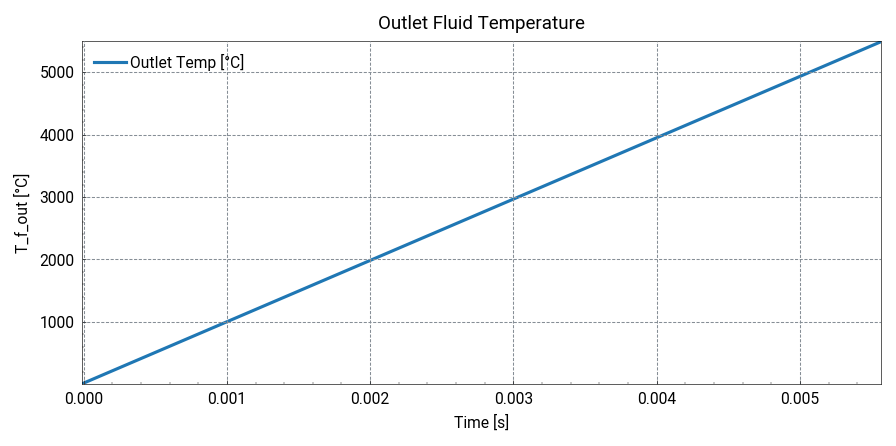

In [8]:
import matplotlib.pyplot as plt

def quick_plot(time_list, T_f_out_list):
    """
    간단한 출구온도 시각화 함수
    """
    plt.figure(figsize=(6, 3), dpi=150)
    plt.plot(time_list, T_f_out_list, color='tab:blue', label='Outlet Temp [°C]')
    plt.xlabel("Time [s]")
    plt.ylabel("T_f_out [°C]")
    plt.title("Outlet Fluid Temperature")
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

# 시각화 함수 호출
quick_plot(time_list, T_f_out_list)

In [3]:
# 부하와 지속 시간 정의
q = 10000      # W
t = 6 * 3600   # s

# 인스턴스 생성 및 설정
hp = GroundSourceHeatPump_cooling()
hp.Q_r_int = q  # 부하 설정
hp.time = t  # 지속 시간 설정
hp.E_pmp = 500

# 계산
hp.system_update()

# 결과
print(f"T_f_in  = {hp.T_f_in - 273.15:.2f} °C")
print(f"T_f_out = {hp.T_f_out - 273.15:.2f} °C")
print(f"Exergy in  = {hp.X_f_in:.2f} W")
print(f"Exergy out = {hp.X_f_out:.2f} W")
print(f"Exergy loss (fluid) = {hp.X_f_out - hp.X_f_in:.2f} W")


T_f_in  = 29.66 °C
T_f_out = 26.07 °C
Exergy in  = 0.32 W
Exergy out = 42.92 W
Exergy loss (fluid) = 42.60 W
